In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
 # colab으로 실행할 때
# from google.colab import drive
# drive.mount('/content/drive')
# train_prod_df = pd.read_csv('/content/drive/MyDrive/kaggle-study/1/data02/train.csv')
# test_prod_df = pd.read_csv('/content/drive/MyDrive/kaggle-study/1/data02/test.csv')

# jupyter로 실행할 때
train_prod_df = pd.read_csv('./data02/train.csv')
test_prod_df = pd.read_csv('./data02/test.csv')

In [5]:
train_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [6]:
test_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

In [7]:
# 데이터에 있는 , 제거 후 float형으로 변환 (문자열 데이터로 되어있음)
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [8]:
train_prod_df.OC.value_counts()

open      286
 close     15
Name: OC, dtype: int64

In [9]:
train_prod_df.employee1.dtype

dtype('float64')

In [10]:
test_prod_df.employee1.dtype

dtype('float64')

In [11]:
train_prod_df.OC = train_prod_df.OC.astype('str').str.replace(' ', '')

In [12]:
train_test_prod = train_prod_df.append(test_prod_df)

In [13]:
train_test_prod.shape

(428, 58)

In [14]:
# factor_columns 와 numeric_columns 로 나눈다.
# 칼럼을 나누는 방법 확인
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

In [15]:
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

In [16]:
# factor_columns 중 비어있는 값 'Not_sure'로 채운다.
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

In [17]:
# numeric_columns 중 비어있는 값 -999로 채운다 -> 왜 -999일까?
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [18]:
# 숫자형으로 인코딩 숫자형으로 인코딩
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

In [19]:
train_test_prod.OC

0      2
1      2
2      2
3      2
4      2
      ..
122    0
123    0
124    0
125    0
126    0
Name: OC, Length: 428, dtype: int32

In [20]:
# train셋과 test셋으로 다시 나눈다. test셋의 OC 값이 0으로 되어있음
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
# submission 파일을 위해 test 셋의 inst_id 값 얻는다.
sub_id = test_prod.inst_id

In [22]:
# 종속변수와 독립변수
dep = 'OC'
indep = train_prod.columns.difference([dep])

In [23]:
train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]

In [24]:
############ Random Forest
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]


In [25]:
############ GBM
estimators = 10
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]

In [26]:
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


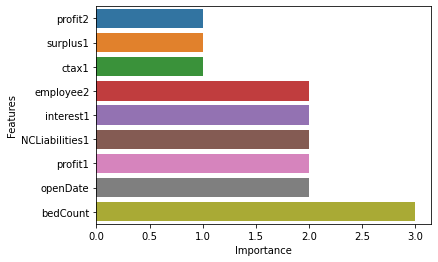

In [27]:
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [28]:
############################################################################
#Ensembling the three models
############################################################################

#Forming the ensemble dataset of the 3 models
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub_XGB['inst_id']
ensemble['XGB'] = sub_XGB['OC']
ensemble['GBM'] = sub_GBM['OC']
ensemble['RF'] = sub_RF['OC']

# Taking the average of all 3 models
ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF'])/3
ensemble['OC'] = (ensemble['ens'] > 0.7).astype('int') #0.7 as the threshold and above that the hospital is closed.

#Printing to see all the hospitals that are classified as closed 
print(ensemble.loc[ensemble['OC'] == 0, ])

ensemble = ensemble.loc[:, ['inst_id', 'OC']]

ensemble.to_csv('ens_XGB_7_RF_4_GBM_2_39.csv', index = False)

     inst_id       XGB       GBM   RF       ens  OC
1          5  0.657157  0.443177  0.8  0.633445   0
2          6  0.409096  0.666447  0.6  0.558514   0
10        24  0.409096  0.925726  0.7  0.678274   0
13        30  0.409096  0.230173  0.8  0.479756   0
22        64  0.409096  0.936367  0.1  0.481821   0
40       123  0.409096  0.842282  0.7  0.650459   0
78       229  0.409096  0.539125  0.6  0.516074   0
84       258  0.409096  0.442562  0.6  0.483886   0
88       293  0.409096  0.724379  0.7  0.611158   0
99       341  0.409096  0.278068  0.4  0.362388   0
120      413  0.409096  0.278068  0.4  0.362388   0
122      424  0.409096  0.312302  0.3  0.340466   0
123      425  0.409096  0.580902  0.7  0.563333   0
124      429  0.409096  0.536108  0.7  0.548401   0
126      431  0.409096  0.536108  0.6  0.515068   0


In [29]:
ensemble.to_csv('submission.csv')